In [1]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

2023-09-30 10:07:01.204946: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-30 10:07:01.229605: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-30 10:07:01.229786: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
!pip install protobuf==3.20.* tensorflow==2.7.0 tensorflow-estimator==2.7.0 keras scikeras tqdm google-auth==2.6.0 google-auth-oauthlib==0.4.6 google-pasta==0.2.0


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [3]:
pip freeze

absl-py==1.4.0
anyio==3.7.1
argon2-cffi==21.3.0
argon2-cffi-bindings==21.2.0
arrow==1.2.3
asttokens==2.2.1
astunparse==1.6.3
attrs==23.1.0
backcall==0.2.0
beautifulsoup4==4.12.2
bleach==6.0.0
cachetools==5.3.1
certifi==2019.11.28
cffi==1.15.1
chardet==3.0.4
comm==0.1.3
contourpy==1.1.0
cycler==0.11.0
dbus-python==1.2.16
debugpy==1.6.7
decorator==5.1.1
defusedxml==0.7.1
exceptiongroup==1.1.2
executing==1.2.0
fastjsonschema==2.17.1
flatbuffers==2.0.7
fonttools==4.40.0
fqdn==1.5.1
gast==0.4.0
google-auth==2.6.0
google-auth-oauthlib==0.4.6
google-pasta==0.2.0
grpcio==1.56.0
h5py==3.9.0
idna==2.8
importlib-metadata==6.7.0
importlib-resources==5.12.0
ipykernel==6.24.0
ipython==8.12.2
ipython-genutils==0.2.0
ipywidgets==8.0.7
isoduration==20.11.0
jedi==0.18.2
Jinja2==3.1.2
joblib==1.3.2
jsonpointer==2.4
jsonschema==4.18.0
jsonschema-specifications==2023.6.1
jupyter==1.0.0
jupyter-console==6.6.3
jupyter-events==0.6.3
jupyter-http-over-ws==0.0.8
jupyter_client==8.3.0
jupyter_core==5.3.1
jupyter

In [4]:
#Array, image processing
import numpy as np
import matplotlib.pyplot as plt
#Model Operation
from keras import Model, Input
import keras.utils as image
# ==>
from keras.wrappers.scikit_learn import KerasRegressor
# Chaned ->
# from scikeras.wrappers import KerasRegressor

from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from keras.preprocessing import image
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import Adam, Adadelta
# io
import glob
from tqdm import tqdm

In [5]:
import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=DeprecationWarning)

In [6]:
from tensorflow.python.framework.config import set_memory_growth
import tensorflow as tf
tf.compat.v1.disable_v2_behavior()
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

Instructions for updating:
non-resource variables are not supported in the long term


In [7]:
filenames = glob.glob("./face_mini/*/*.jpg")
len(filenames)

# Load image files and Resize (h,w,ch) -> h = w < 100 , ch = 3 (R,G,B)
all_images = []

for idx, img_path in enumerate(filenames):
    img = image.load_img(img_path, target_size=(100, 100), interpolation="nearest") # nearest ถ้าไม่ถึง 100 เอาข้าง ๆ มาแปะให้เต็ม 100

    # convert the image to an array
    img = image.img_to_array(img)

    # Normalized color imageimg
    img = img / 255 # ปรับ scale ให้เหลือแค่ 0-255
    all_images.append(img)
    if(len(all_images) > 3000):
        break
        
    
all_images = np.array(all_images)
all_images.shape # จำนวน size size rgb

(3001, 100, 100, 3)

In [8]:
# แบ่งเป็น 3 set = train, test, validate(รูปที่ไม่เคยเห็น)

# split data into train and validation data
train_x, test_x = train_test_split(all_images, random_state=32, test_size=0.3)
train_x, val_x = train_test_split(train_x, random_state=32, test_size=0.3)
print(train_x.shape)# รูปที่เอาไว้ train
print(test_x.shape)# รูปที่เอาไว้ test
print(val_x.shape)# รูปที่เอาไว้ validate

(1470, 100, 100, 3)
(901, 100, 100, 3)
(630, 100, 100, 3)


In [9]:
# add noise
noise_factor = 0.2 # scalar between 0 - 1 ลองอย่ํางน้อย 2 ค่า
Nmean = 0
Nstd = 0.5

x_train_noisy = train_x + (noise_factor * np.random.normal(loc=Nmean, scale=Nstd, size=train_x.shape) )
x_val_noisy = val_x + ( noise_factor * np.random.normal(loc=Nmean, scale=Nstd, size=val_x.shape) )
test_x_noisy = test_x + ( noise_factor * np.random.normal(loc=Nmean, scale=Nstd, size=test_x.shape) )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


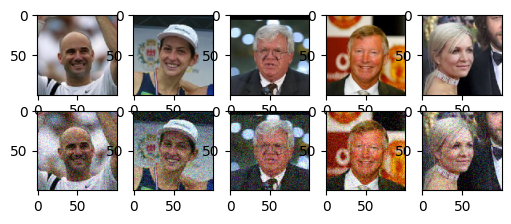

In [10]:
fig = plt.figure(figsize=(6, 6))
size = 5
for i in range(0, size):
  fig.add_subplot(size, size, i+1)
  plt.imshow(train_x[i], cmap="jet")
  fig.add_subplot(size, size, size+i+1)
  plt.imshow(x_train_noisy[i], cmap="jet")

In [11]:
# กำหนด Encoder Architecture
Input_img = Input(shape=(100, 100, 3))
# encoding architecture
x1 = Conv2D(256, (3, 3), activation='relu', padding='same')(Input_img)
x2 = Conv2D(128, (3, 3), activation='relu', padding='same')(x1)
x2 = MaxPool2D( (2, 2))(x2)
encoded = Conv2D(64, (3, 3), activation='relu', padding='same')(x2)

# กำหนด Decoder Architecture
# decoding architecture
x3 = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
x3 = UpSampling2D((2, 2))(x3)
x2 = Conv2D(128, (3, 3), activation='relu', padding='same')(x3)
x1 = Conv2D(256, (3, 3), activation='relu', padding='same')(x2)
decoded = Conv2D(3, (3, 3), padding='same')(x1)

# กำหนด optimizer setting
autoencoder = Model(Input_img, decoded) # เอา model มาใช้
autoencoder.compile(optimizer='adam', loss='mse') # -> loss ใช้ Mean Square Error
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 256)     7168      
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 128)     295040    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 128)      0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 64)        73792     
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 50, 64)        36928     
                                                             

In [12]:
# กำหนด Training parameter
# epoch ทดลองอย่างน้อย 1 ค่า [ 2, 4, 8, 16 ]
# batch_size ทดลองอย่างน้อย 2 ค่า [16, 32, 64, 128]

epochs = 16
batch_size = 32 # ยิ่งสูง ยิ่งละเอียด ยิ่งรันนาน
early_stopper = EarlyStopping(monitor="val_loss", mode="min", patience=2)

# เริ่มการ Training
history = autoencoder.fit(x=x_train_noisy, # รูปที่เอามาเทรน
                          y=train_x,       # รูปที่ไม่มี noise
                          batch_size=batch_size,
                          epochs=epochs, 
                          shuffle=True, 
                          validation_data=(x_val_noisy, val_x), 
                          callbacks=[early_stopper])

Train on 1470 samples, validate on 630 samples
Epoch 1/16


2023-09-30 10:07:11.226018: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-30 10:07:11.226653: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-30 10:07:11.226954: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-30 10:07:11.227140: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

1470/1470 [==============================] - ETA: 0s - loss: 0.1234

/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


1470/1470 [==============================] - 26s 18ms/sample - loss: 0.1234 - val_loss: 0.0150
Epoch 2/16
1470/1470 [==============================] - 20s 14ms/sample - loss: 0.0107 - val_loss: 0.0085
Epoch 3/16
1470/1470 [==============================] - 20s 14ms/sample - loss: 0.0049 - val_loss: 0.0035
Epoch 4/16
1470/1470 [==============================] - 21s 14ms/sample - loss: 0.0035 - val_loss: 0.0030
Epoch 5/16
1470/1470 [==============================] - 21s 14ms/sample - loss: 0.0029 - val_loss: 0.0026
Epoch 6/16
1470/1470 [==============================] - 21s 14ms/sample - loss: 0.0033 - val_loss: 0.0026
Epoch 7/16
1470/1470 [==============================] - 21s 14ms/sample - loss: 0.0024 - val_loss: 0.0022
Epoch 8/16
1470/1470 [==============================] - 21s 14ms/sample - loss: 0.0020 - val_loss: 0.0020
Epoch 9/16
1470/1470 [==============================] - 21s 14ms/sample - loss: 0.0019 - val_loss: 0.0018
Epoch 10/16
1470/1470 [==============================] - 

In [13]:
# ทดสอบ autoencoder model ด้วย validation
predictions = autoencoder.predict(x_val_noisy)
predictions.shape

/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


(630, 100, 100, 3)

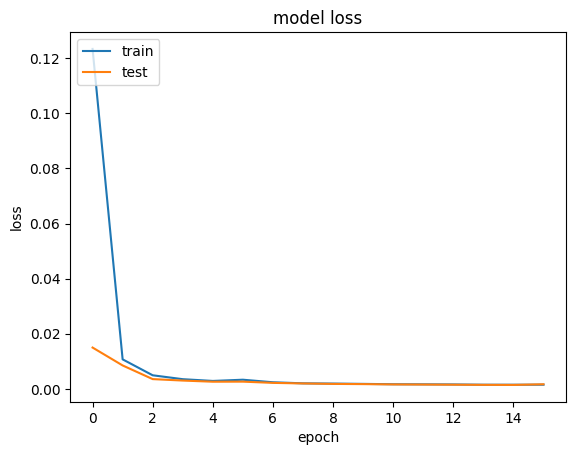

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

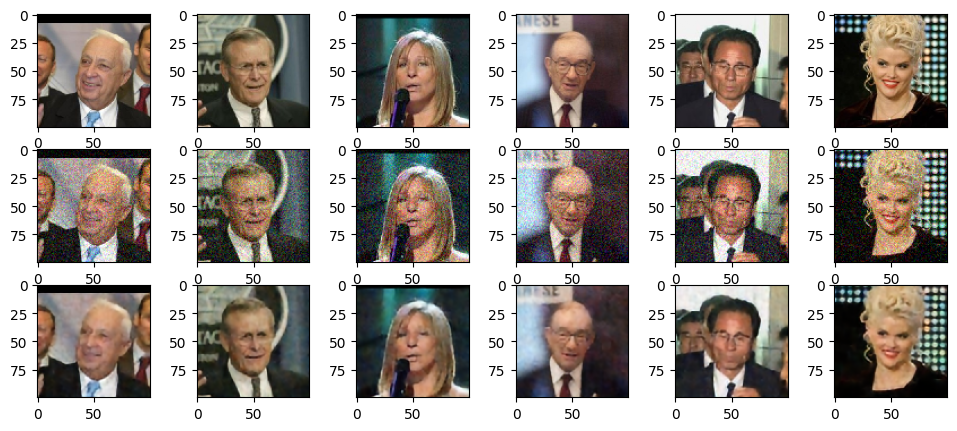

In [15]:
fig = plt.figure(figsize=(12, 12))
size = 6
for i in range(0, size):
  fig.add_subplot(size+1, size, i+1)
  plt.imshow(val_x[i])
  fig.add_subplot(size+1, size, size+i+1)
  plt.imshow(x_val_noisy[i])
  fig.add_subplot(size+1, size, size+size+i+1)
  plt.imshow(predictions[i])